<a href="https://colab.research.google.com/github/danielluca00/ML_Bone_fracture_detection/blob/main/bone_fracture_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# cloning detectron2
import sys, os, distutils.core
#!python -m pip install pyyaml==5.1
#!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
#!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

In [2]:
# importing dependencies
import torch, detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
print("detectron2 version:", detectron2.__version__)

import numpy as np
import os, json, cv2, random
import PIL
import matplotlib.pyplot as plt

#importing detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

SEED = 9
THRESHOLD = 0.3

detectron2 version: 0.6
matplotlib data path: /home/dani2/ml_project/venv/lib/python3.12/site-packages/matplotlib/mpl-data
CONFIGDIR=/home/dani2/.config/matplotlib
interactive is False
platform is linux
CACHEDIR=/home/dani2/.cache/matplotlib
font search path [PosixPath('/home/dani2/ml_project/venv/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf'), PosixPath('/home/dani2/ml_project/venv/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/afm'), PosixPath('/home/dani2/ml_project/venv/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/pdfcorefonts')]
generated new fontManager


In [3]:
# creating coco instances
from detectron2.data.datasets import register_coco_instances
from detectron2.structures import BoxMode

for d in ["train", "valid", "test"]:
    register_coco_instances(f"bone_fractures_{d}", {},
                            f"input/{d}_annotations.coco.json",
                            f"input/{d}/images")

In [ ]:
# import kagglehub

# kagglehub.dataset_download('banddaniel/bone-fracture-detection-detection-coco-annots')
# kagglehub.dataset_download('pkdarabi/bone-fracture-detection-computer-vision-project')


100%|██████████| 259k/259k [00:00<00:00, 76.4MB/s]

Extracting files...


100%|██████████| 84.1M/84.1M [00:00<00:00, 112MB/s]

Extracting files...


In [4]:
# examples from the training dataset

import random
from detectron2.utils.visualizer import Visualizer

my_dataset_train_metadata = MetadataCatalog.get("bone_fractures_train")
train_dataset_dicts = DatasetCatalog.get("bone_fractures_train")

def create_random_images(dataset_dict,dataset_metadata, seed, image_scale = 0.7):
    np.random.seed(seed)
    images = np.random.permutation(dataset_dict)[:2]

    fig, axs = plt.subplots(1,2, figsize = (12,6), dpi = 100)
    for i in range(2):
        im = images[i]
        img_link = im['file_name']
        img_id = im['image_id']
        img = cv2.imread(img_link)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        visualizer = Visualizer(img, metadata= dataset_metadata, scale=image_scale)
        vis = visualizer.draw_dataset_dict(im)
        final_img = vis.get_image()

        axs[i].set_title('image id: ' + str(img_id), fontsize = 10)
        axs[i].axis('off')
        axs[i].imshow(final_img)

WARNING [03/02 23:33:37 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[03/02 23:33:37 d2.data.datasets.coco]: Loaded 3631 images in COCO format from input/train_annotations.coco.json


Loaded backend module://matplotlib_inline.backend_inline version unknown.
Loaded backend module://matplotlib_inline.backend_inline version unknown.
findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
findfont: score(FontEntry(fname='/home/dani2/ml_project/venv/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerifDisplay.ttf', name='DejaVu Serif Display', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/home/dani2/ml_project/venv/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/cmtt10.ttf', name='cmtt10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/home/dani2/ml_project/venv/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/cmmi10.ttf', name='cmmi10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: sco

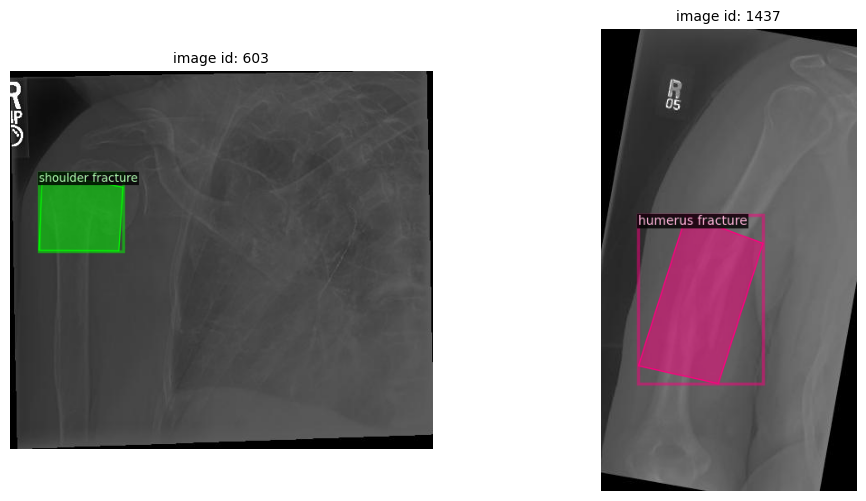

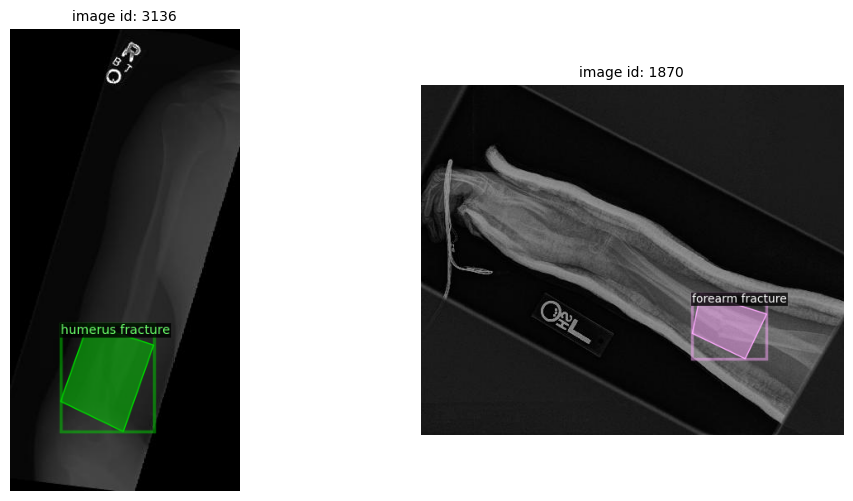

In [5]:
# my_dataset_train_metadata = MetadataCatalog.get("bone_fractures_train")
# train_dataset_dicts = DatasetCatalog.get("bone_fractures_train")

create_random_images(train_dataset_dicts, my_dataset_train_metadata, seed = 5 , image_scale = 1)
create_random_images(train_dataset_dicts, my_dataset_train_metadata, seed = 9 , image_scale = 1)

Faster R-CNN w/ResNeXt 101 FPN Model, Training

In [7]:
from detectron2.engine import DefaultTrainer

EPOCHS = 500
NUM_CLASSES = 8
BASE_LR = 0.001

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("bone_fractures_train")
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = BASE_LR
cfg.SOLVER.MAX_ITER = EPOCHS
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512
cfg.MODEL.ROI_HEADS.NUM_CLASSES = NUM_CLASSES

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# uncomment below to train
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[03/02 23:40:49 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (9, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (9,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (32, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (32,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, 

[03/02 23:40:49 d2.engine.train_loop]: Starting training from iteration 0
[03/02 23:41:15 d2.utils.events]:  eta: 0:10:57  iter: 19  total_loss: 2.215  loss_cls: 2.044  loss_box_reg: 0.01468  loss_rpn_cls: 0.1612  loss_rpn_loc: 0.01266    time: 1.3889  last_time: 1.1136  data_time: 0.0051  last_data_time: 0.0032   lr: 3.8962e-05  max_mem: 6504M
[03/02 23:41:41 d2.utils.events]:  eta: 0:10:19  iter: 39  total_loss: 0.666  loss_cls: 0.5013  loss_box_reg: 0.0246  loss_rpn_cls: 0.1198  loss_rpn_loc: 0.01071    time: 1.3656  last_time: 1.1621  data_time: 0.0033  last_data_time: 0.0019   lr: 7.8922e-05  max_mem: 6504M
[03/02 23:42:08 d2.utils.events]:  eta: 0:09:54  iter: 59  total_loss: 0.2737  loss_cls: 0.07677  loss_box_reg: 0.02042  loss_rpn_cls: 0.1649  loss_rpn_loc: 0.01165    time: 1.3588  last_time: 1.5293  data_time: 0.0035  last_data_time: 0.0062   lr: 0.00011888  max_mem: 6505M
[03/02 23:42:33 d2.utils.events]:  eta: 0:09:20  iter: 79  total_loss: 0.2105  loss_cls: 0.09307  loss_b

In [8]:
# Saving the model

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = THRESHOLD
predictor = DefaultPredictor(cfg)

import pickle
with open("cfg.pkl", "wb") as f:
    pickle.dump(cfg, f)

[03/02 23:51:48 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...
[Checkpointer] Loading from ./output/model_final.pth ...


Faster R-CNN w/ResNeXt 101 FPN Training Results

In [10]:
# original code from https://eidos-ai.medium.com/training-on-detectron2-with-a-validation-set-and-plot-loss-on-it-to-avoid-overfitting-6449418fbf4e

def reading_metrics_from_json(metrics_path):
    metrics = []

    with open(metrics_path, 'r') as f:
        for line in f:
            metrics.append(json.loads(line))
    return metrics


def metric(metrics, specific_metric):
    metric = []
    for i in range(len(metrics)):
        try:
            metric.append(metrics[i][specific_metric])
        except KeyError:
            pass

    return metric

In [12]:
train_metrics = reading_metrics_from_json('./output/metrics.json')

total_loss = metric(train_metrics, 'total_loss')
cls_acc = metric(train_metrics, 'fast_rcnn/cls_accuracy')
false_neg = metric(train_metrics, 'fast_rcnn/false_negative')
loss_box_reg = metric(train_metrics, 'loss_box_reg')
iters = np.arange(1,EPOCHS,EPOCHS/len(total_loss))

Text(0.5, 1.0, 'False Negative')

findfont: Matching sans\-serif:style=italic:variant=normal:weight=normal:stretch=normal:size=15.0.
findfont: score(FontEntry(fname='/home/dani2/ml_project/venv/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerifDisplay.ttf', name='DejaVu Serif Display', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/home/dani2/ml_project/venv/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/cmtt10.ttf', name='cmtt10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/home/dani2/ml_project/venv/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/cmmi10.ttf', name='cmmi10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/home/dani2/ml_project/venv/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizOneSymReg.ttf', name='STIXSizeOneS

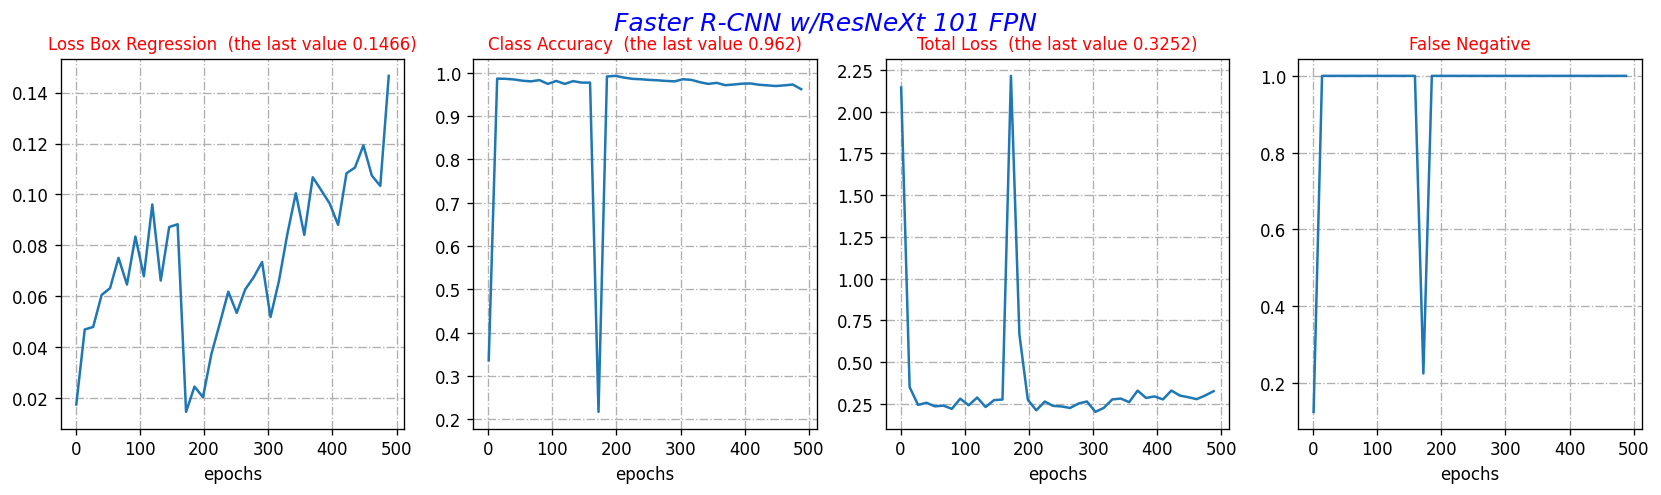

In [13]:
fig, axs = plt.subplots(1,4, figsize = (17, 4), dpi = 120)
fig.suptitle('Faster R-CNN w/ResNeXt 101 FPN', color = 'blue', fontsize=15,  style = "italic")

axs[0].grid(linestyle = 'dashdot')
axs[0].plot(iters, loss_box_reg)
axs[0].set_xlabel('epochs', fontsize = 10)
axs[0].set_title('Loss Box Regression', fontsize = 10)
tit0 = ' (the last value {0:.4f})'.format(loss_box_reg[-1])
axs[0].set_title('Loss Box Regression ' + tit0, fontsize = 10, color = 'red')

axs[1].grid(linestyle = 'dashdot')
axs[1].plot(iters, cls_acc)
axs[1].set_xlabel('epochs', fontsize = 10)
tit1 = ' (the last value {0:.3f})'.format(cls_acc[-1])
axs[1].set_title('Class Accuracy ' + tit1, fontsize = 10, color = 'red')

axs[2].grid(linestyle = 'dashdot')
axs[2].plot(iters, total_loss)
axs[2].set_xlabel('epochs', fontsize = 10)
tit2 = ' (the last value {0:.4f})'.format(total_loss[-1])
axs[2].set_title('Total Loss ' + tit2, fontsize = 10, color = 'red')

axs[3].grid(linestyle = 'dashdot')
axs[3].plot(iters, false_neg)
axs[3].set_xlabel('epochs', fontsize = 10)
axs[3].set_title('False Negative', fontsize = 10, color = 'red')

Faster R-CNN w/ResNeXt 101 FPN Test Results

In [14]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("bone_fractures_test", False, output_dir="./output/")
test_loader = build_detection_test_loader(cfg, "bone_fractures_test")
inference_on_dataset(trainer.model, test_loader, evaluator)

[03/02 23:52:34 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
WARNING [03/02 23:52:34 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[03/02 23:52:34 d2.data.datasets.coco]: Loaded 169 images in COCO format from input/test_annotations.coco.json
[03/02 23:52:34 d2.data.build]: Distribution of instances among all 8 categories:
|   category    | #instances   |   category    | #instances   |   category    | #instances   |
|:-------------:|:-------------|:-------------:|:-------------|:-------------:|:-------------|
|     bones     | 0            | elbow posit.. | 17           | fingers pos.. | 27           |
| forearm fra.. | 14           |    humerus    | 0            | humerus fra.. | 15           |
| shoulder fr.. | 17           | wrist posit.. | 6            |               |              |
|     total     | 96           |               |              |               |  

OrderedDict([('bbox',
              {'AP': 2.07321211137872,
               'AP50': 6.282814096776527,
               'AP75': 0.012036932991323515,
               'APs': 0.0,
               'APm': 2.1787384640655114,
               'APl': 1.1811545531162722,
               'AP-bones': nan,
               'AP-elbow positive': 1.5638805259836324,
               'AP-fingers positive': 2.4648133399959398,
               'AP-forearm fracture': 0.0,
               'AP-humerus': nan,
               'AP-humerus fracture': 0.5794161978433255,
               'AP-shoulder fracture': 1.0984893371226887,
               'AP-wrist positive': 6.732673267326731})])

Faster R-CNN w/ResNeXt 101 FPN Test Predictions

In [17]:
my_dataset_test_metadata = MetadataCatalog.get("bone_fractures_test")
from detectron2.utils.visualizer import ColorMode
dataset_dicts = DatasetCatalog.get("bone_fractures_test")


# A function for plotting an original image's bbox and predicted bbox
def create_predictions(dataset_dict, dataset_metadata, seed, image_scale = 0.8):
    np.random.seed(seed=seed)
    images = np.random.permutation(dataset_dict)[:3]

    fig, axs = plt.subplots(3,2, figsize = (10,15), dpi = 200)

    for i in range(3):
        im = images[i]
        img_link = im['file_name']
        img_id = im['image_id']
        img = cv2.imread(img_link)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        visualizer1 = Visualizer(img, metadata= dataset_metadata, scale=image_scale)

        vis_original = visualizer1.draw_dataset_dict(im)
        original_bbox = vis_original.get_image()

        visualizer2 = Visualizer(img, metadata= dataset_metadata, scale=image_scale)
        outputs = predictor(img)
        out = visualizer2.draw_instance_predictions(outputs["instances"].to("cpu"))
        out_img = cv2.cvtColor(out.get_image(), cv2.COLOR_BGR2RGB)
        final_bbox = cv2.cvtColor(out_img, cv2.COLOR_BGR2RGB)

        axs[i][0].set_title('original bbox (id: ' + str(img_id) +')', fontsize = 8)
        axs[i][0].axis('off')
        axs[i][0].imshow(original_bbox)

        axs[i][1].set_title('predicted bbox (id: ' + str(img_id) +')', fontsize = 8)
        axs[i][1].axis('off')
        axs[i][1].imshow(final_bbox)

WARNING [03/02 23:53:57 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[03/02 23:53:57 d2.data.datasets.coco]: Loaded 169 images in COCO format from input/test_annotations.coco.json


findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=8.412175114121165.
findfont: score(FontEntry(fname='/home/dani2/ml_project/venv/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerifDisplay.ttf', name='DejaVu Serif Display', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/home/dani2/ml_project/venv/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/cmtt10.ttf', name='cmtt10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/home/dani2/ml_project/venv/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/cmmi10.ttf', name='cmmi10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/home/dani2/ml_project/venv/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizOneSymReg.ttf', name=

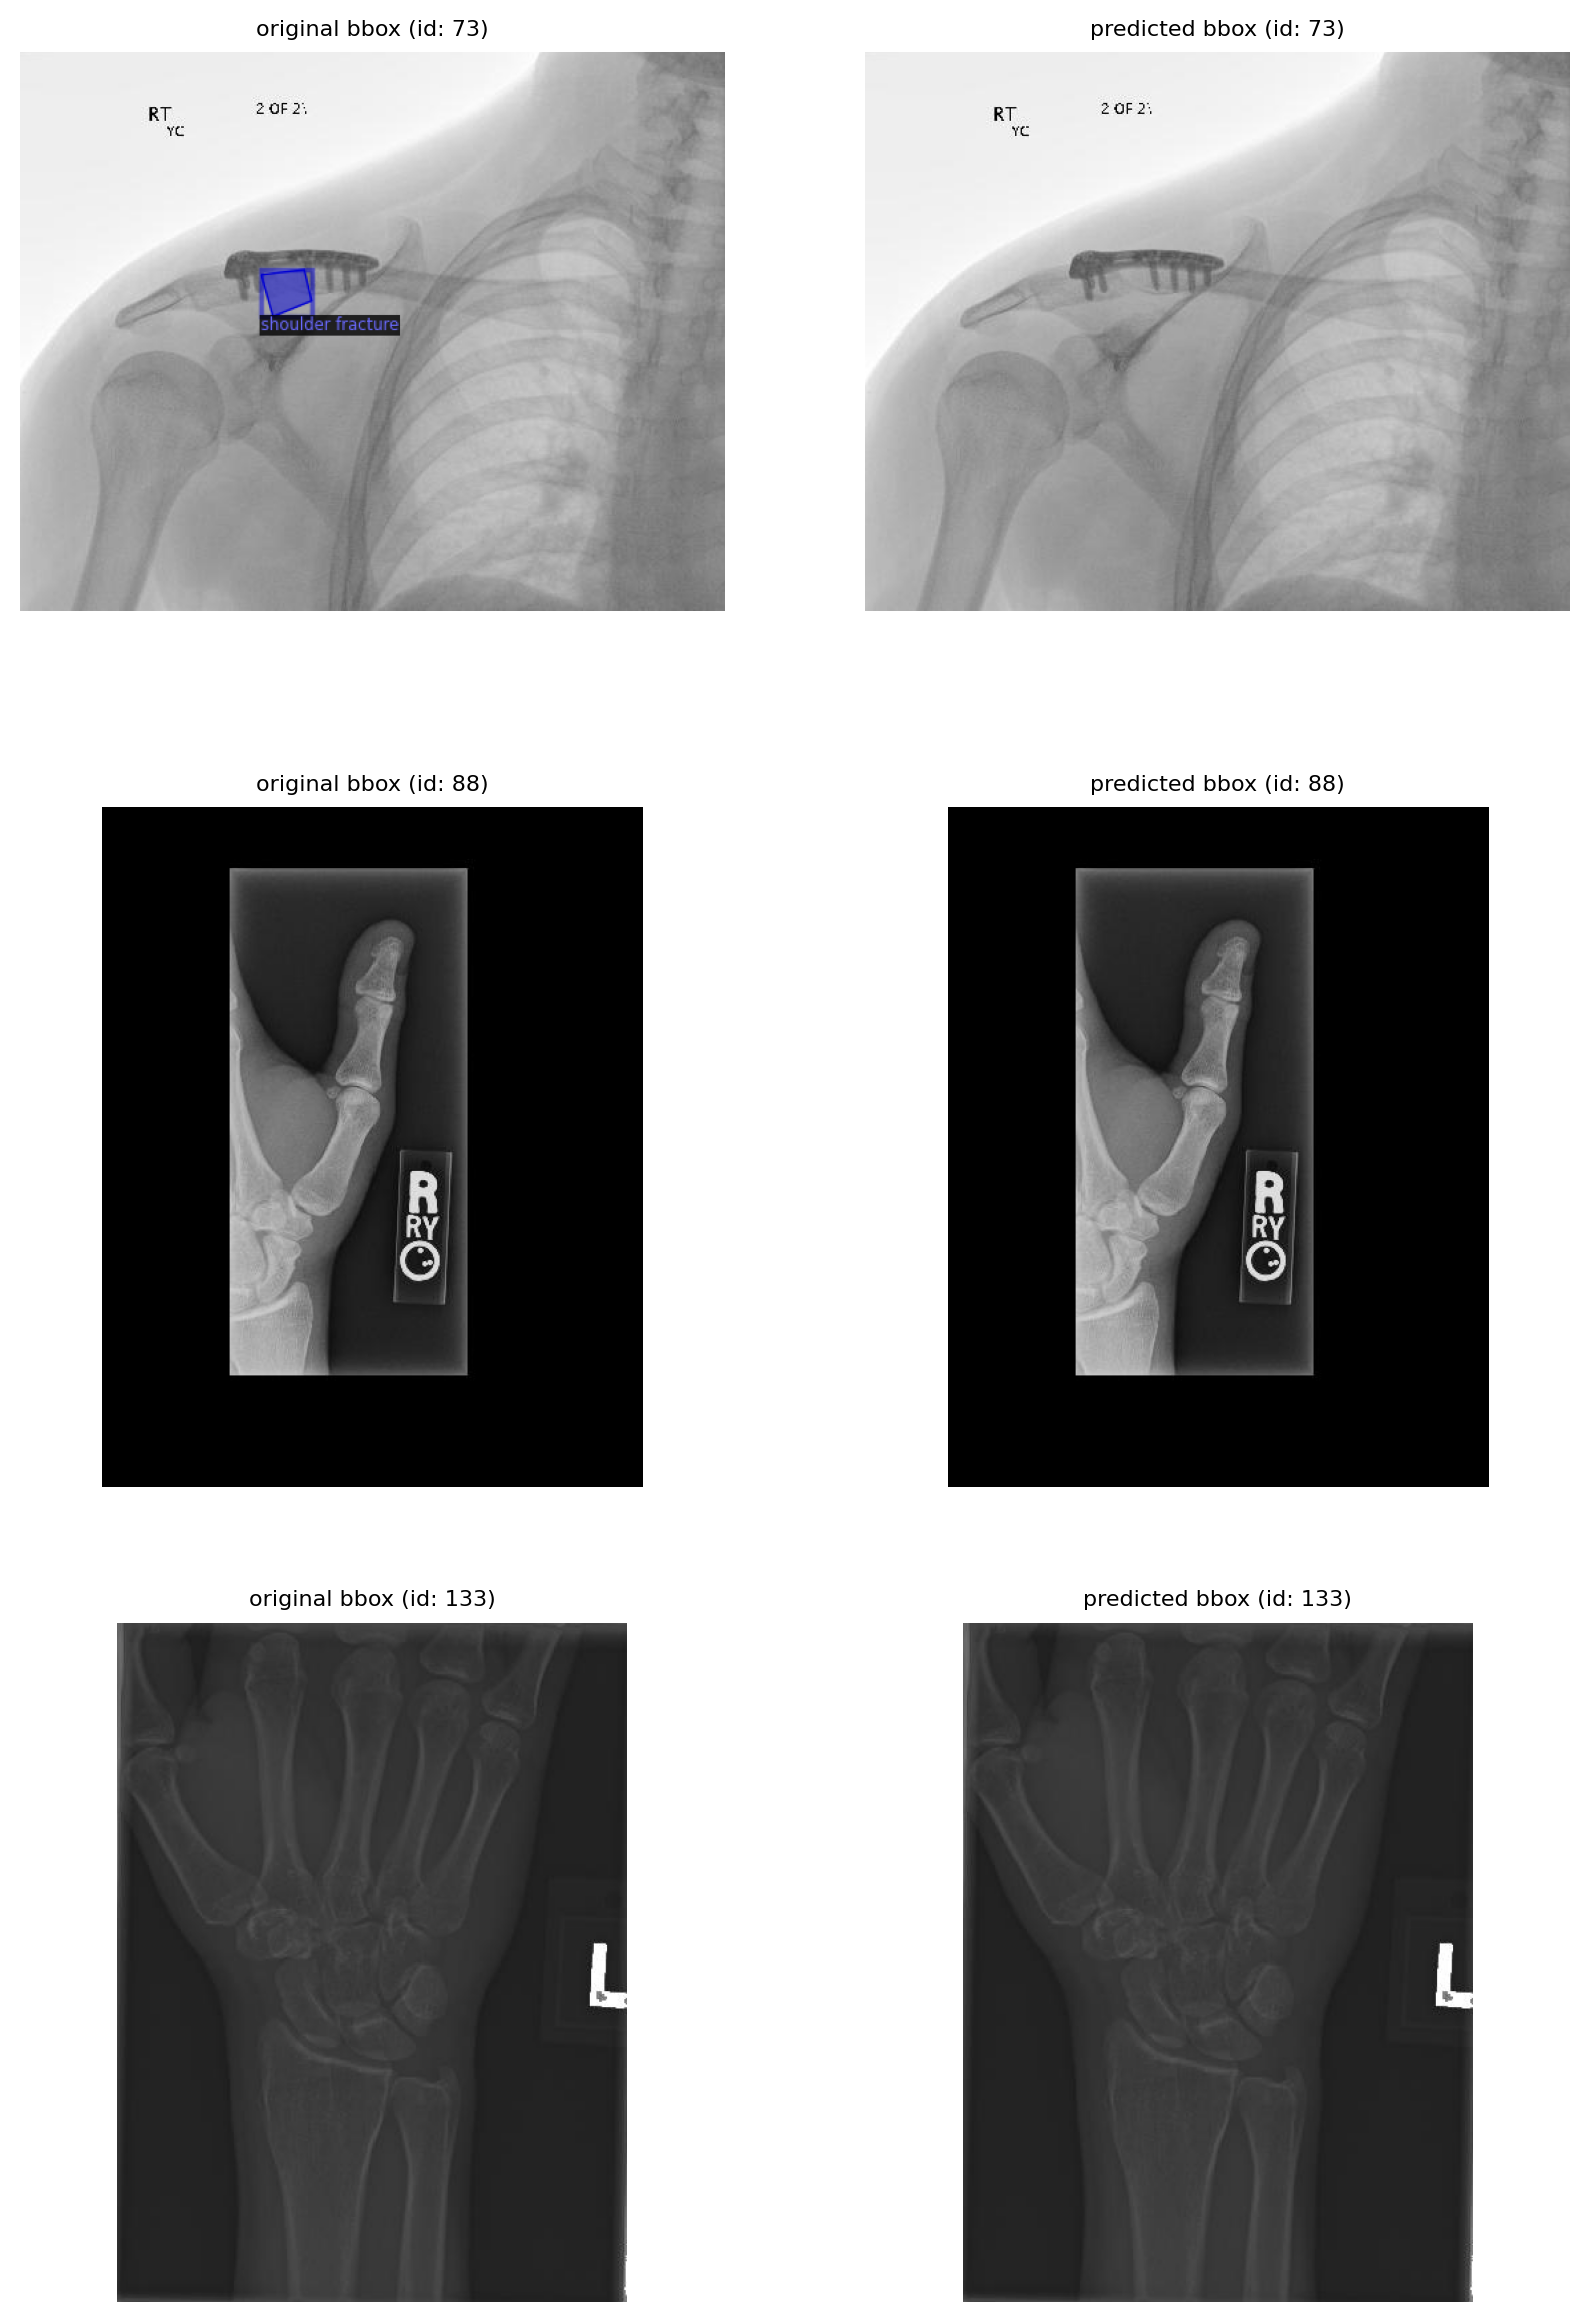

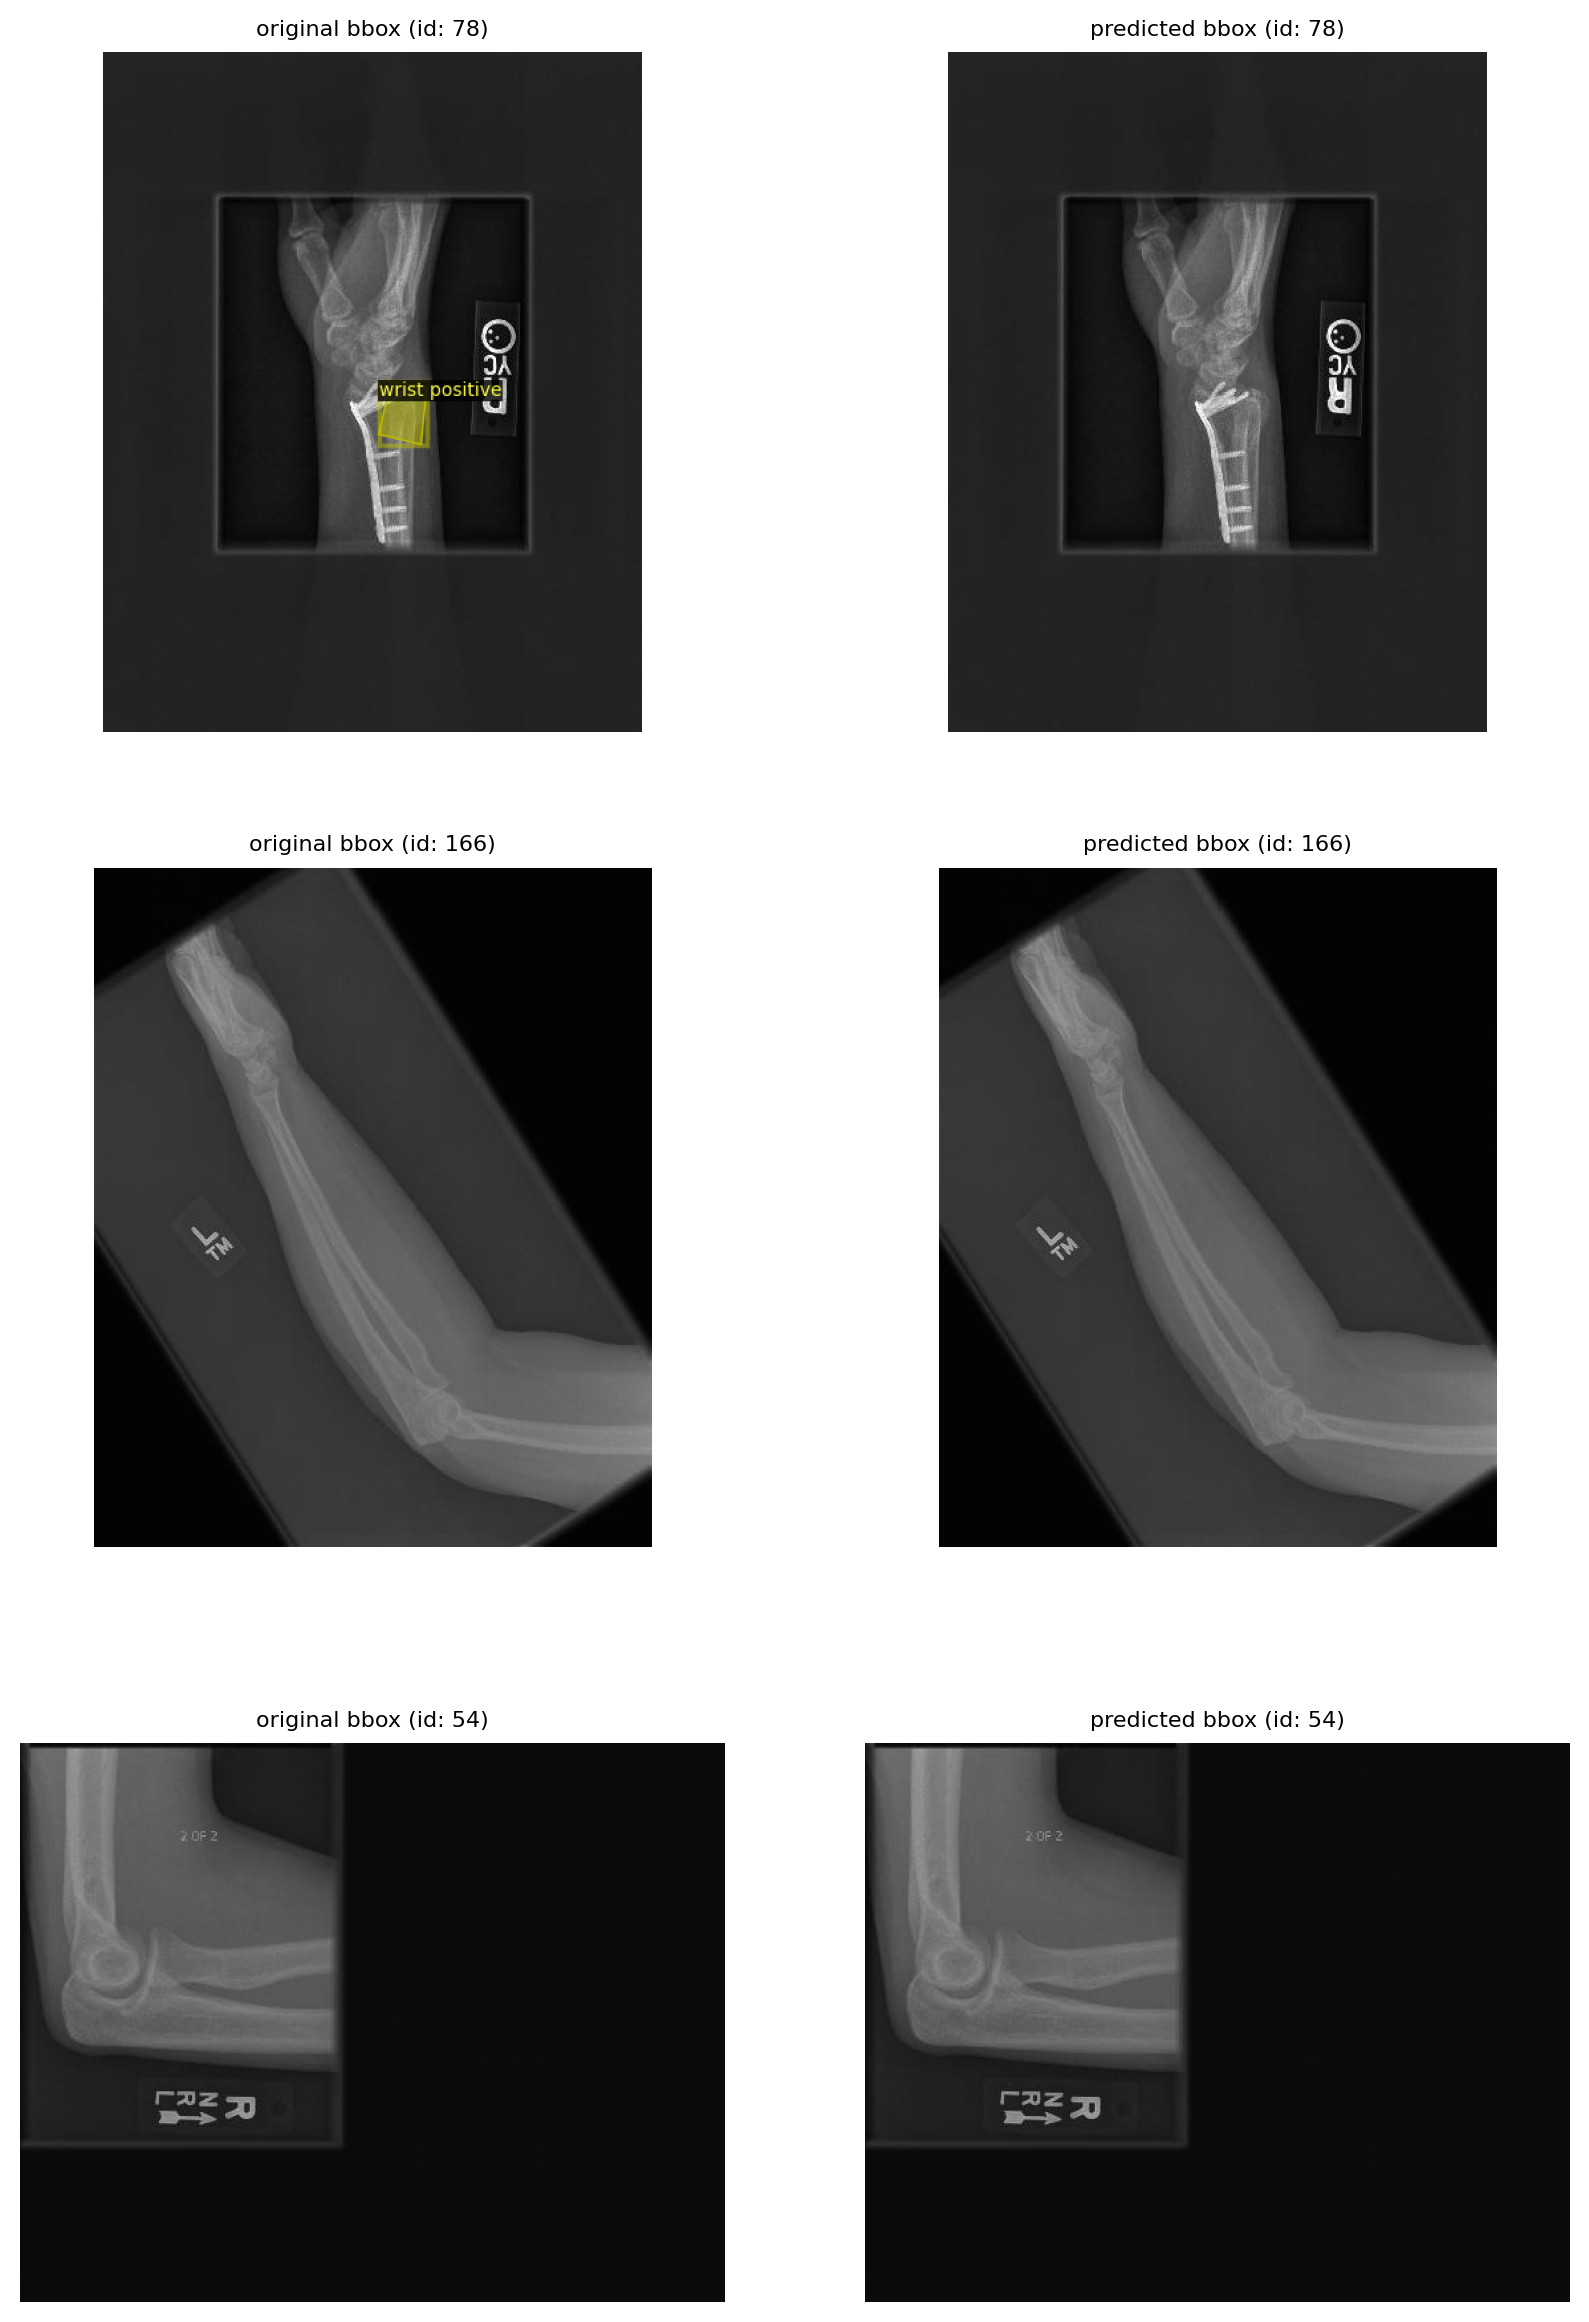

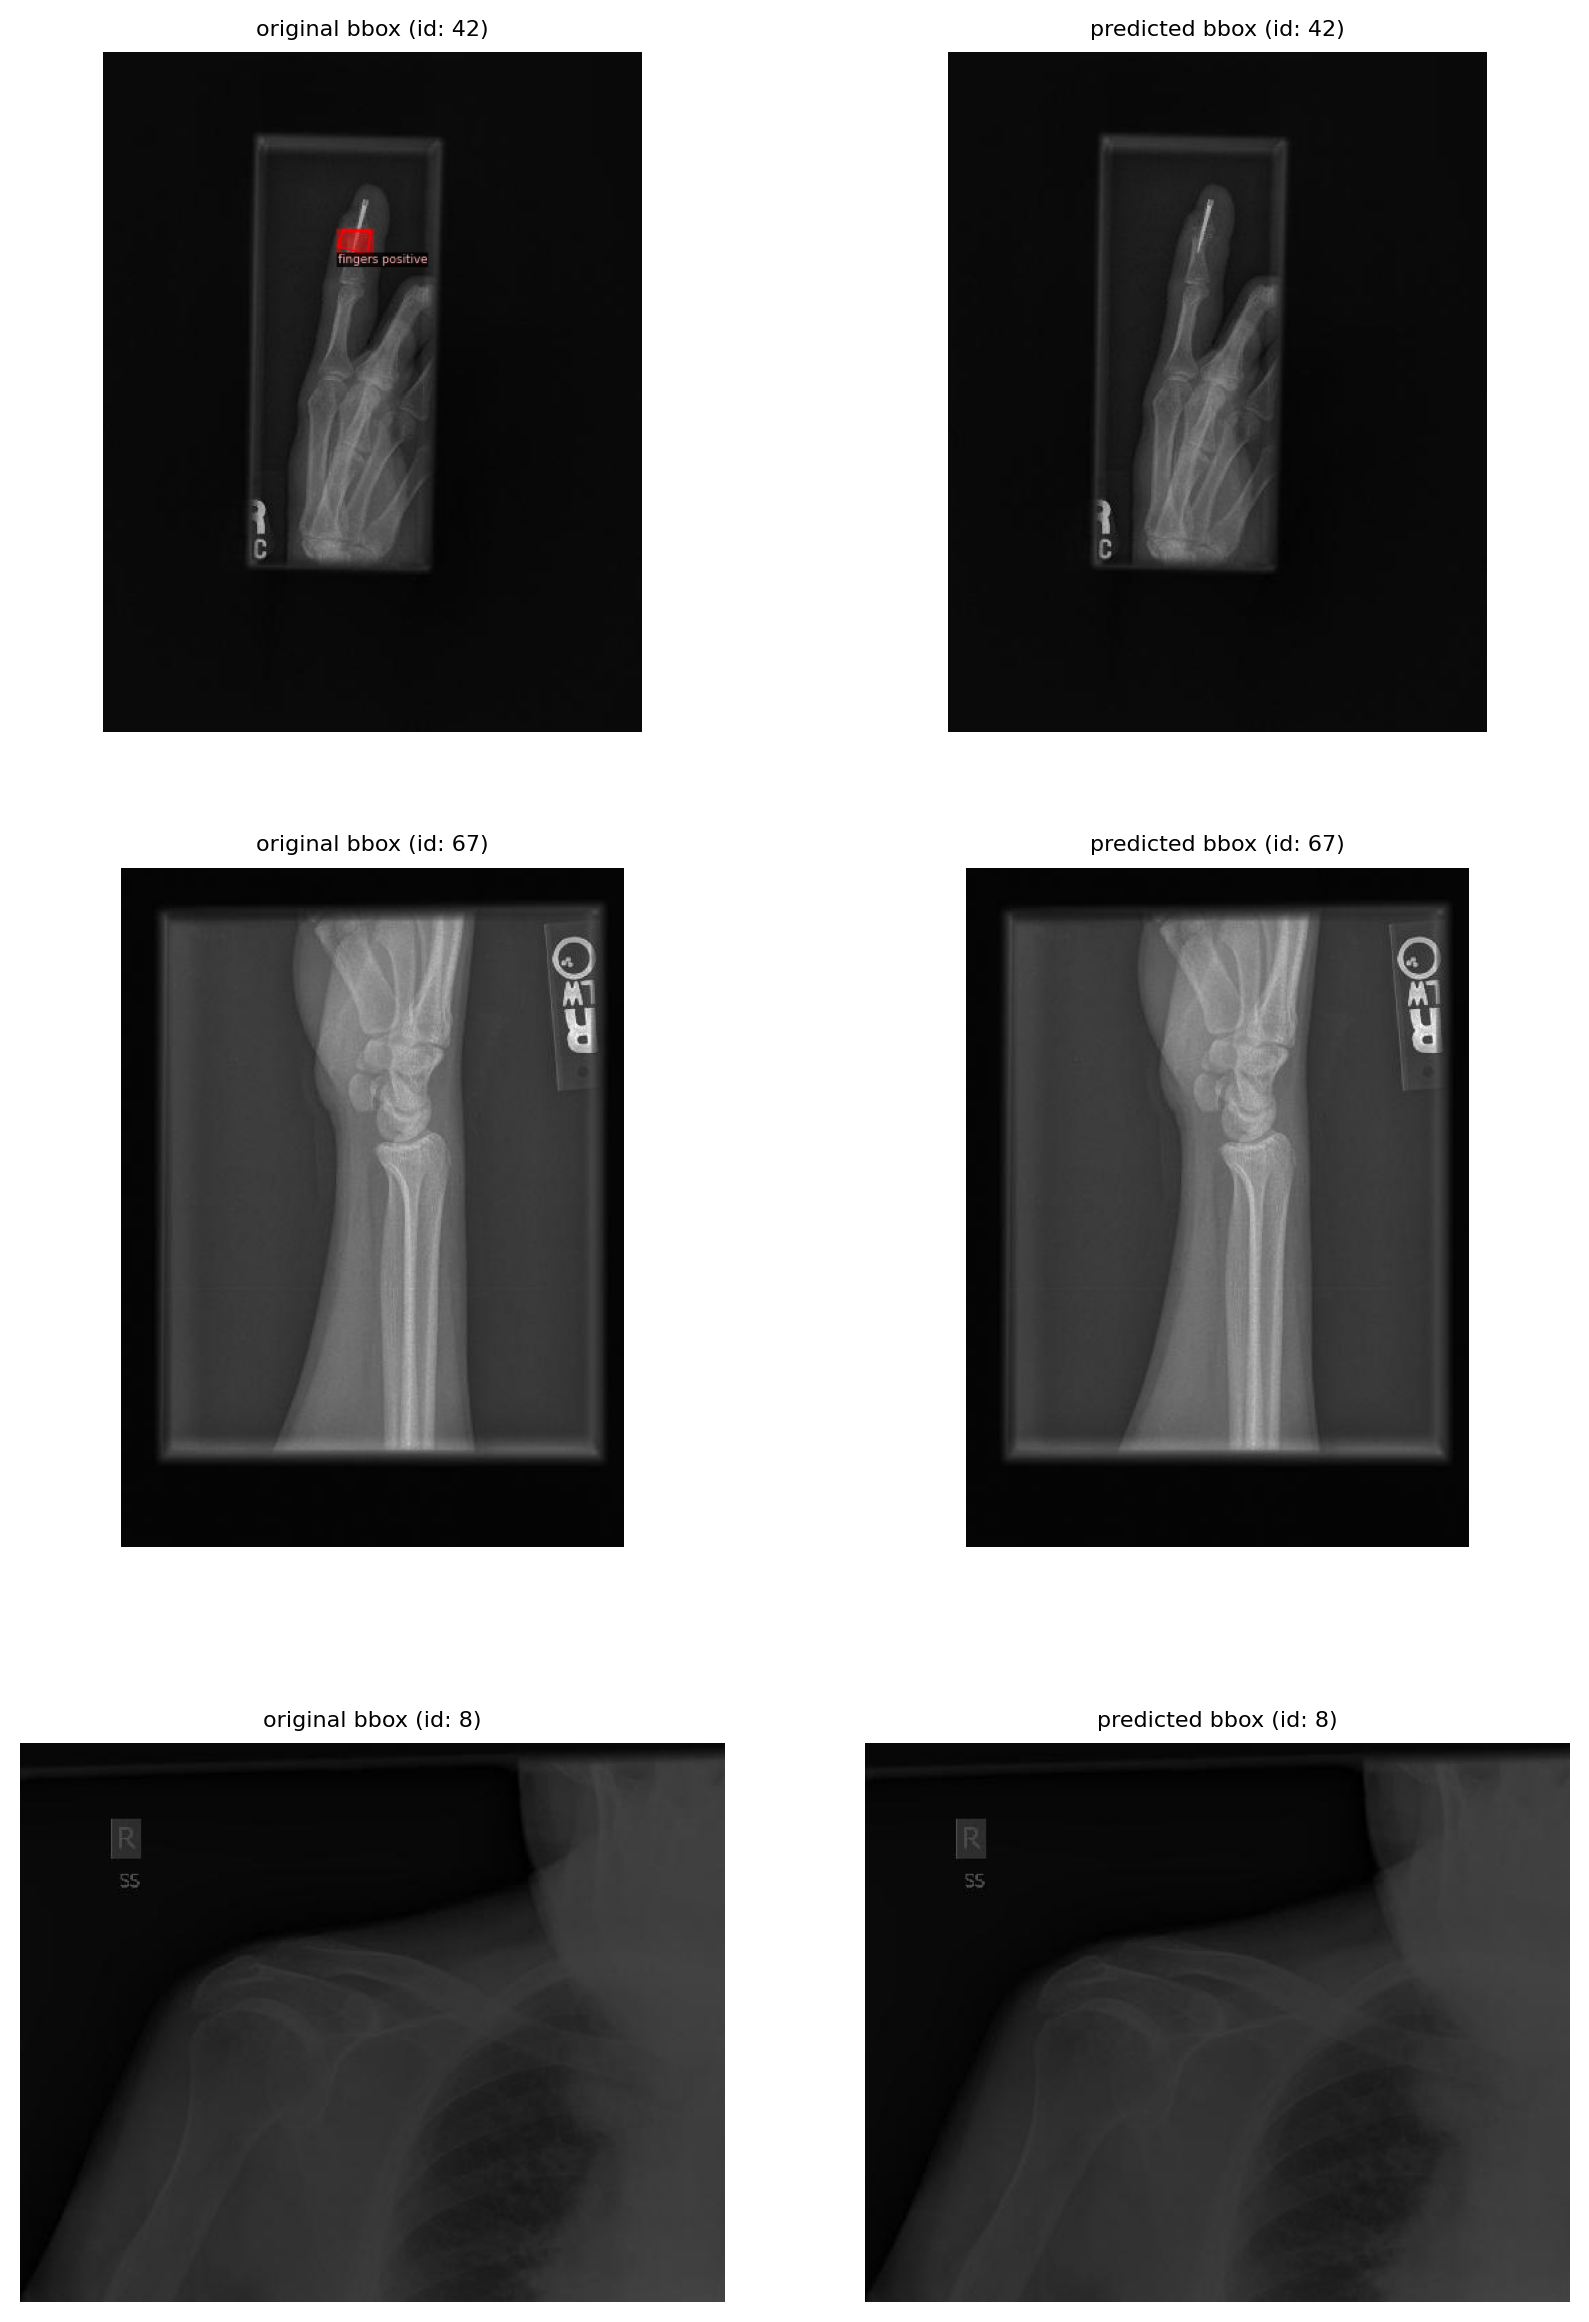

In [18]:
create_predictions(dataset_dicts,my_dataset_test_metadata,seed = 3, image_scale=1)
create_predictions(dataset_dicts,my_dataset_test_metadata,seed = 93, image_scale=1)
create_predictions(dataset_dicts,my_dataset_test_metadata,seed = 643, image_scale=1)